# Low-rank approximation on $\mathcal{P}(d)$ - the space of $d$-dimensional SPD matrices

In this notebook we want to get some intuition in different approaches for computing low-rank approximations for manifold-valued signals

In [276]:
using Manifolds
using Manopt
using LinearAlgebra
using Random
using Plots

In [277]:
# initialize SPD power manifold P(d)^d1
dd = 3  # size of the SPD matrices, i.e., ∈ R^d×d
M_base = SymmetricPositiveDefinite(dd)
d = manifold_dimension(M_base)
d1 = 100  # size of the signal
M = PowerManifold(M_base, NestedPowerRepresentation(), d1)

PowerManifold(SymmetricPositiveDefinite(3), NestedPowerRepresentation(), 100)

### Generate a data set

In [278]:
e = 1. * Matrix(I, dd, dd)
# compute basis on M_base
Θ = get_basis(M_base, e, DefaultOrthonormalBasis())
#  construct data
Q = fill(e, d1)
# draw random tvectors 
τ = 2.  # variance
σ = .05  # variance
# Xₑⁱ = zeros(d)
# Xₑⁱ[1] = 1.
# Xₑ = get_vector(M_base, e, Xₑⁱ, Θ)
Xₑ = Θ.data[1]

Random.seed!(31)
predata = [exp(M_base, e, sqrt(τ) * randn(1)[1] * Xₑ) for i in 1:d1]

data = [exp(M_base, predata[i], random_tangent(M_base, predata[i], Val(:Gaussian), σ)) for i in 1:d1] # ∈ P(3)^d1
log_Q_data = log(M, Q, data)  # ∈ T_e P(3)^d1
println(Xₑ)

[1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]


We want to investigate how reliable both ranks are, i.e., we don't want that something looks low-rank, but in reality is higher rank

In [279]:
# compute SVD
# compute Gramm Matrix
Gramm_Q = [inner(M_base, e, log_Q_data[k], log_Q_data[l]) for k=1:d1, l=1:d1]
# compute Σ and V
(sqSigma, V) = eigen(Symmetric(Gramm_Q), d1-min(d1-1,d-1):d1)
# compute U
U = [1/sqrt(sqSigma[i]) * sum([V[k,i] * log_Q_data[k] for k in 1:d1]) for i in 1:d]

sqSigma

6-element Vector{Float64}:
   0.20030061285052259
   0.23473294140142664
   0.31265402158642613
   0.3306014192967376
   0.3946823528716723
 480.59320854019387

In [280]:
U[end]

3×3 Matrix{Float64}:
 -0.999971    0.00196278  0.00126507
  0.00196278  0.00624225  0.00162757
  0.00126507  0.00162757  0.00169994

In [281]:
function β(κ)
    (κ < 0) && return sinh(sqrt(-κ)) / ( sqrt((-κ)))
    (κ > 0) && return sin(sqrt(κ)) / (sqrt(κ))
    return 1.0 # cuvature zero.
end

β (generic function with 1 method)

In [282]:
# we want to compute the metric tensor entries in default ONB at e and then compute g_ij so that we don't have to reevaluate this all the time
gᵢⱼ = zeros(d,d)
for k=1:d1
    Ξₖ = get_basis(M_base, e, DiagonalizingOrthonormalBasis(log_Q_data[k]))
    κₖ = Ξₖ.data.eigenvalues
    βₖ = [β(κₖ[l]) for l in 1:d]
    gᵢⱼ += 1/d1 * [sum([βₖ[l]^2 * inner(M_base, e, Θ.data[i], Ξₖ.data.vectors[l]) * inner(M_base, e, Θ.data[j], Ξₖ.data.vectors[l]) for l=1:d]) for i=1:d, j=1:d]
end
gᵢⱼ

6×6 Matrix{Float64}:
  1.04169       4.7573       1.15559    -0.0390015   -0.0135617   -0.00268737
  4.7573      583.679        8.40348    -4.73989     -0.899143    -0.0174109
  1.15559       8.40348    527.562      -0.0683755   -3.04085     -1.08721
 -0.0390015    -4.73989     -0.0683755   1.03909      0.00735125  -9.16997e-5
 -0.0135617    -0.899143    -3.04085     0.00735125   1.01955      0.00621049
 -0.00268737   -0.0174109   -1.08721    -9.16997e-5   0.00621049   1.00278

In [283]:
# compute SVD
# compute rescaled Gramm Matrix
reweighted_Gramm_Q = [sum([gᵢⱼ[i,j] * get_coordinates(M_base, e, log_Q_data[k], Θ)[i] * get_coordinates(M_base, e, log_Q_data[l], Θ)[j] for i=1:d, j=1:d]) for k=1:d1, l=1:d1]
# compute Σ and V
(reweighted_sqSigma, reweighted_V) = eigen(Symmetric(reweighted_Gramm_Q ), d1-min(d1-1,d-1):d1)
# compute U
reweighted_U = [1/sqrt(reweighted_sqSigma[i]) * sum([reweighted_V[k,i] * log_Q_data[k] for k in 1:d1]) for i in 1:d]

reweighted_sqSigma

6-element Vector{Float64}:
   0.21302896045266548
   0.2671352985274962
   0.3244334499955881
 165.4392037998312
 188.58425319157402
 493.9524469033112

In [284]:
ref_distance = distance(M, data, Q)
tangent_distances_r = zeros(d)
distances_r = zeros(d)
reweighted_tangent_distances_r = zeros(d)
reweighted_distances_r = zeros(d)

for rank in 1:d
    log_Q_data_r = [sum([U[i] * sqrt(sqSigma[i]) * V[k,i] for i in d-rank+1:d]) for k in 1:d1]
    reweighted_log_Q_data_r = [sum([reweighted_U[i] * sqrt(reweighted_sqSigma[i]) * reweighted_V[k,i] for i in d-rank+1:d]) for k in 1:d1]
    # expoentiate back
    data_r = exp(M, Q, log_Q_data_r)
    reweighted_data_r = exp(M, Q, reweighted_log_Q_data_r)


    # compute tangent space error
    tangent_distances_r[rank] = norm(M, Q,  log_Q_data - log_Q_data_r)
    reweighted_tangent_distances_r[rank] = norm(M,Q,  log_Q_data - reweighted_log_Q_data_r )


    # compute manifold error
    distances_r[rank] = distance(M, data, data_r)
    reweighted_distances_r[rank] = distance(M, data, reweighted_data_r)
end
# TODO plot distances for every rank 1:6
# It seems to pick the correct vectors, but the singular values do not yet reflect that well how low the rank actually is...
# -> we can reweight the U's and the sigmas by normalizing them wrt old metric
# the SPD manifold always has a couple of directions with negative curvature, check whether these are the same as the obtained directions

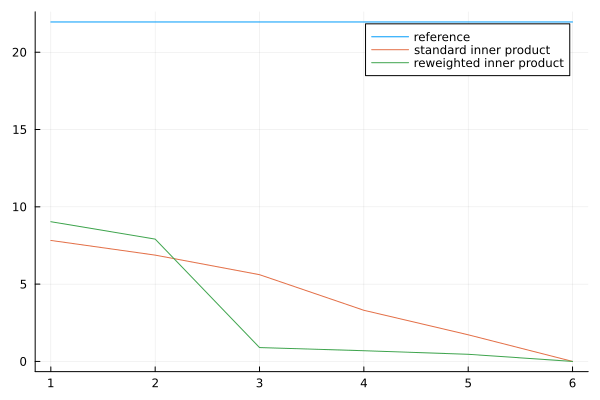

In [285]:
plot(1:d, [ref_distance * ones(d), distances_r, reweighted_distances_r], label = ["reference" "standard inner product" "reweighted inner product"])